In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_7_after_words_attention'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
categories_all = sorted(all_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NOT_CHANGED', 'NUMBERS', 'PLAIN', 'VERBATIM']
6


### Utils stuff

In [7]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [8]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [9]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [10]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [11]:
sample_data = all_data[all_data['class'] != 'NOT_CHANGED']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)

Data rows: 659544,  (dropped rows: 9258648)


In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
%%timeit
balanced_data_sample_row()

105 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      16950
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                                               101271
token_id                                                       9
class                                                      PLAIN
before                                                         -
after                                                         to
class_org                                                  PLAIN
a_word_ind                                               [57, 0]
sentence       journal of the neurological sciences , 220 ( 1...
Name: 88946, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NUMBERS : -170 -> minus one hundred seventy <EOS> [119, 9, 10, 33, 0]
journal of child psychology and psychiatry , 45 : 135 <SAMPLE> .
torch.Size([1, 5, 104])


In [17]:
%%timeit
get_random_sample()

153 µs ± 6.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Model functions

In [18]:
use_cuda = True

In [260]:
MAX_ATTENTION_LENGTH = 50

### Encoder

In [261]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[:,ei]), 1)
                
        #output = torch.cat((output_words, output_chars), 1)
        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return hidden_states_cat[-1], hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [263]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t)
    
encoder_output, encoder_outputs = test_encoder_single_sample()
encoder_output.size()
encoder_outputs.size()


Narr


torch.Size([384])

torch.Size([50, 384])

### Decoder

In [23]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (embedding): Embedding(1351, 384)
  (attn): Linear (768 -> 100)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 100])]

In [206]:
torch.arange(0, 9).view(1,3,3)


(0 ,.,.) = 
  0  1  2
  3  4  5
  6  7  8
[torch.FloatTensor of size 1x3x3]

In [218]:
torch.bmm(torch.FloatTensor([1,1,2]).view(1,1,-1), torch.arange(0, 9).view(1,3,3))


(0 ,.,.) = 
  15  19  23
[torch.FloatTensor of size 1x1x3]

In [24]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 100])]

Variable containing:
 1145
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

cape


# Training etc

### Accuracy

In [65]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_intput = torch.LongTensor([word_index])
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('nineteen eighty',
 'nineteen eighty',
 'nineteen eighty',
 ('1980',
  [7, 27, 0],
  'NUMBERS',
  'in <SAMPLE> , body changes made the wagon more aerodynamic for better fuel efficiency .'))

In [92]:
tmp = test_model_single_sample(None, return_more=True)
tmp[0]
len(tmp[2])
tmp[3][0]

'nineteen ninety nine'

4

'1999'

In [109]:
tmp[2][3].topk(4)

(Variable containing:
  1.0000e+00  1.6132e-07  4.4260e-10  1.3326e-10
 [torch.cuda.FloatTensor of size 1x4 (GPU 0)], Variable containing:
   7  31  91   0
 [torch.cuda.LongTensor of size 1x4 (GPU 0)])

In [72]:
tmp[3]

('&', [55, 0], 'VERBATIM', 'the barnes <SAMPLE> noble review .')

In [55]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

κ              => alpha          || [167, 0] 
                  limnakaro ( greek : λ ι μ ν α <SAMPLE> α ρ ο ) is a small ( approx .
EUCC           => e u u c        || [28, 43, 21, 21, 0] 
                  eucc counts with a regional office for the mediterranean sea , the <SAMPLE> mediterranean centre in barcelona , spain .


In [28]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=1000)

Accuracy: 0.00% (       0/    1000)
CPU times: user 22 s, sys: 152 ms, total: 22.2 s
Wall time: 22.2 s


0.0

### Training

In [29]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_intput = torch.LongTensor([word_index])
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [60]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [31]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_7_after_words_attention


In [32]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   5.723   |   3.57: - ->  (✗: [57, 0]) 
Saved model to data/models/whole_gen_7_after_words_attention/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  0m 45s)   5.576   |   6.46: dr -> <EOS> (✗: [113, 0]) (forcing)
    27  54% (  0m 45s)   5.280   |   5.89: - -> <EOS> (✗: [57, 0]) (forcing)
    36  72% (  0m 45s)   4.936   |   5.17: - -> <EOS> (✗: [57, 0]) (forcing)
    45  90% (  0m 45s)   4.442   |   5.33: gt -> <EOS> <EOS> (✗: [53, 30, 0]) (forcing)


In [33]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 7s)   2.954   |   2.61: # -> <EOS> (✗: [109, 0]) (forcing)


In [34]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 16s)   2.818   |   2.03: st -> and (✗: [102, 0]) 
  3000  22% (  0m 32s)   2.558   |   2.13: dr -> to (✗: [113, 0]) (forcing)
  4000  33% (  0m 49s)   2.355   |   4.13: # -> to (✗: [175, 0]) (forcing)
  5000  44% (   1m 4s)   2.286   |   2.11: ltd -> versus (✗: [118, 0]) 
  6000  56% (  1m 21s)   2.314   |   1.45: st -> to (✗: [102, 0]) 
  7000  67% (  1m 37s)   2.223   |   3.05: ATP -> p <EOS> <EOS> (✗: [22, 30, 24, 0]) (forcing)
  8000  78% (  1m 54s)   2.093   |   4.11: 14 May 1943 -> the <EOS> of <EOS> <EOS> <EOS> <EOS> (✗: [11, 96, 12, 66, 7, 41, 13, 0]) (forcing)
  9000  89% (  2m 10s)   2.151   |   0.02: & -> and (✗: [55, 0]) (forcing)
 10000 100% (  2m 28s)   2.004   |   3.35: 1767 -> nineteen hundred <EOS> (✗: [81, 39, 18, 0]) (forcing)


In [35]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (   3m 4s)   1.089   |   0.00: & -> and (✗: [55, 0]) (forcing)
 30000  22% (  6m 16s)   0.857   |   0.49: colours -> colors (✗: [197, 0]) (forcing)
 40000  33% (  9m 38s)   0.627   |   0.66: adrsta -> a (✗: [22, 26, 35, 17, 30, 22, 0]) 
 50000  44% (  13m 4s)   0.680   |   0.00: & -> and (✗: [55, 0]) (forcing)
Saved model to data/models/whole_gen_7_after_words_attention/50000_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
 60000  56% ( 17m 38s)   0.632   |   1.02: 28 May 2015 -> the twenty of of july fifteen fifteen (✗: [11, 6, 80, 12, 66, 6, 51, 0]) (forcing)
 70000  67% ( 20m 56s)   0.554   |   0.00: dr -> doctor (✗: [113, 0]) 
 80000  78% ( 24m 14s)   0.569   |   3.76: ξ -> iota (✗: [367, 0]) (forcing)
 90000  89% ( 27m 31s)   0.561   |   0.00: metres -> meters (✗: [108, 0]) (forcing)
100000 100% ( 30m 59s)   0.507   |   0.00: : -> to (✗: [57, 0]) (forcing)
Saved model to data/models/whole_gen_7_after_words_attention/100000_(EncoderRNN/DecoderRNN)
Accuracy: 

In [61]:
train_iterations(n_iters=30, print_every=5, teacher_forcing_ratio=0.5, lr=0.001)

100145  17% (   0m 0s)   0.963   |   0.00: & -> and (✓) (forcing)
100150  33% (   0m 0s)   0.600   |   0.00: & -> and (✓) (forcing)
100155  50% (   0m 0s)   0.542   |   0.00: & -> and (✓) (forcing)
100160  67% (   0m 0s)   0.621   |   0.02: MV -> m v (✓) (forcing)
100165  83% (   0m 0s)   0.530   |   0.00: & -> and (✓) (forcing)
100170 100% (   0m 0s)   0.523   |   0.01: 1886 -> eighteen eighty six (✓) 


In [62]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110170   3% (  3m 14s)   0.484   |   0.00: jr -> junior (✓) 
120170   7% (  6m 30s)   0.488   |   0.03: 1960 -> nineteen sixty (✓) (forcing)
130170  10% (  9m 36s)   0.468   |   0.00: & -> and (✓) 
140170  13% ( 12m 50s)   0.505   |   0.10: IOR -> i o r (✓) (forcing)
Saved model to data/models/whole_gen_7_after_words_attention/150000_(EncoderRNN/DecoderRNN)
Accuracy: 76.46% (    7646/   10000)
150170  17% ( 17m 19s)   0.457   |   0.33: J. A. M. -> j a m (✓) (forcing)
160170  20% ( 20m 50s)   0.422   |   0.00: - -> to (✓) 
170170  23% ( 24m 12s)   0.437   |   0.00: behaviour -> behavior (✓) 
180170  27% ( 27m 23s)   0.432   |   0.00: & -> and (✓) (forcing)
190170  30% ( 30m 50s)   0.424   |   0.00: - -> to (✓) (forcing)
Saved model to data/models/whole_gen_7_after_words_attention/200000_(EncoderRNN/DecoderRNN)
Accuracy: 79.93% (    7993/   10000)
200170  33% (  35m 5s)   0.457   |   0.00: & -> and (✓) (forcing)
210170  37% ( 38m 29s)   0.435   |   0.00: Ph -> p h (✓) 
220170  40% ( 41m 

KeyboardInterrupt: 

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

In [176]:
import matplotlib.ticker as ticker

input:   ['april', 'thirtieth', 'twenty', 'fifteen']
output:  ['april', 'thirtieth', 'twenty', 'fifteen']


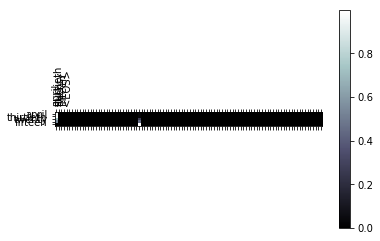

In [194]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    #output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input: ', [words_after_common[w] for w in sample[1]])
    print(output)

    showAttention(input_sentence, output_words, attentions)

output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
sample_input = [words_after_common[w] for w in sample[1][:-1]]
print('input:  ', sample_input)
print('output: ', decoded_output)

attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

debug_show_attention(sample_input, decoded_output, attns)
#debug_eval_sample_show_attention()

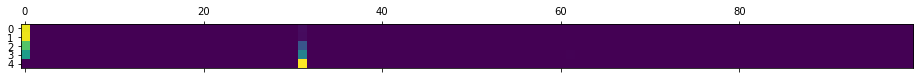

In [195]:
tmp = [r/sum(r) for r in attns]
plt.matshow(tmp)

In [189]:
attns[2]/sum(attns[2])

array([  9.99980748e-01,   9.92407198e-12,   9.14397296e-18,
         1.80283575e-19,   1.89822130e-10,   5.82498404e-17,
         6.55974017e-22,   3.32263016e-06,   3.80407387e-19,
         1.55128228e-17,   4.37699182e-12,   1.29124508e-16,
         2.60259817e-19,   5.70190056e-21,   1.04794817e-20,
         7.80802356e-09,   9.30033284e-20,   4.89955488e-17,
         7.25619118e-19,   4.47494472e-13,   5.47296264e-10,
         7.37232265e-17,   1.34295270e-14,   6.67527472e-23,
         9.58605033e-19,   4.16910517e-12,   1.43581158e-19,
         1.77782237e-16,   1.46719429e-19,   1.78220064e-10,
         8.51443436e-20,   1.56323222e-05,   1.01024068e-23,
         4.07252681e-20,   4.30995799e-18,   1.48798811e-18,
         4.30555408e-18,   3.61784605e-19,   9.95954296e-21,
         9.93238219e-20,   2.51739159e-19,   9.62528040e-22,
         1.78173557e-13,   1.87591884e-19,   1.06507755e-18,
         1.80711804e-12,   1.35986731e-17,   1.52575645e-20,
         1.17458678e-20,